In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from thesis_toolbox.utils import get_locations_CLP, source_contrib_composite_difference, read_depostion_datasets
from thesis_toolbox.composites.create_composites import detrend_timeseries,select_years_to_composite
from thesis_toolbox.plot.plot_source_contribution import composite_depositon_facet_plot, depositon_facet_plot
from thesis_toolbox.plot.tools import add_letter
import matplotlib as mpl
import numpy as np
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

In [6]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../../'
    to_file= False

In [7]:
def calc_ratio(ds_tot, ds_f, ds_diff):
    ds_out = ds_tot.isel(year=0).copy()
    for dtvar, dvar, dv in zip(ds_tot,ds_f, ds_diff):
        ds_tot_strong = ds_tot[dtvar].sel(year=ds_diff[dv].strong_years)
        ds_tot_weak = ds_tot[dtvar].sel(year=ds_diff[dv].weak_years)
        ds_f_strong = ds_f[dvar].sel(year=ds_diff[dv].strong_years)
#         print(type(ds_diff[dv].weak_years))
        ds_f_weak = ds_f[dvar].sel(year=ds_diff[dv].weak_years)
        frac_weak = ds_f_weak/ds_tot_weak.values
        frac_strong = ds_f_strong/ds_tot_strong.values
        out_da = frac_strong.mean(dim='year')-frac_weak.mean(dim='year')
#         return frac_strong, frac_weak
#         return out_da
        ds_out = ds_out.assign({dtvar:out_da})
    return ds_out

In [8]:
# locs = get_locations_CLP()
locs =['SHAPOTOU','SACOL','BAODE','LUOCHUAN','LINGTAI','LANTIAN']
# locs_bar = ['SHAPOTOU','SACOL','LINGTAI','BADOE','LUOCHUAN','LANTIAN']
wetdep2m =source_contrib_composite_difference(path, locs, 'wetdep','2micron', norm=True)
drydep2m = source_contrib_composite_difference(path,locs,'drydep','2micron',norm=True)

wetdep20m = source_contrib_composite_difference(path, locs, 'drydep', '20micron')
drydep20m = source_contrib_composite_difference(path, locs, 'wetdep','20micron')



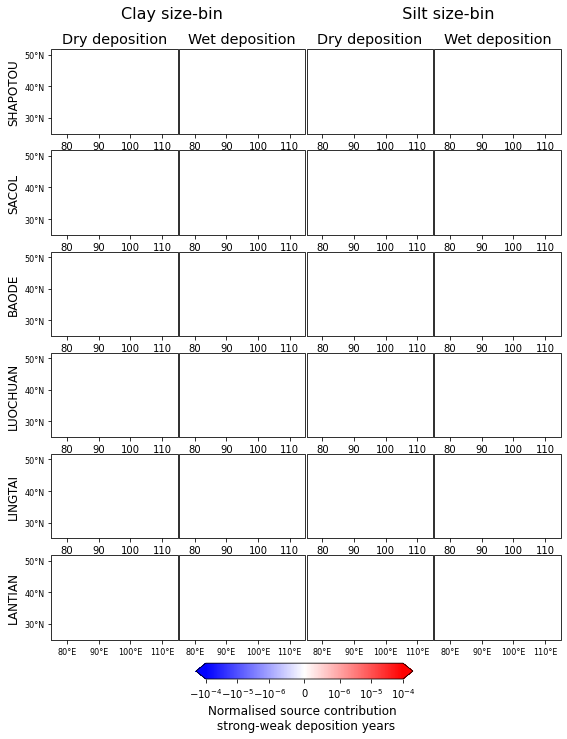

In [13]:
fig, ax = plt.subplots(nrows=6, ncols=4,  figsize=(8.3*1.1, 11), subplot_kw={'projection':ccrs.PlateCarree()})
composite_depositon_facet_plot(drydep2m,ax=ax[:,0],lin_tresh=1e-6,vmin=-1e-4,vmax=1e-4,upper_bound=1e-6, 
                               lower_bound=-1e-6, add_labels=False, colorbar=False,
                                hspace=0.1, wspace=0.05, add_site_name=False, no_tick_labels=True)

composite_depositon_facet_plot(wetdep2m,ax=ax[:,1],lin_tresh=1e-6,vmin=-1e-4,vmax=1e-4,upper_bound=1e-6, 
                               lower_bound=-1e-6, add_labels=False, colorbar=False,
                                hspace=0.1, wspace=0.05, add_site_name=False, no_tick_labels=True)

norm=matplotlib.colors.SymLogNorm(linthresh=1e-6, linscale=1,vmin=-1e-4, vmax=1e-4,base=10)

cax = fig.add_axes([0.345, 0.08,0.33,0.02])
fig.colorbar(cm.ScalarMappable(norm=norm,cmap='bwr'),cax=cax, label='Normalised source contribution \n strong-weak deposition years'
                            ,extend='both', orientation='horizontal')

composite_depositon_facet_plot(drydep20m,ax=ax[:,2],lin_tresh=1e-6,vmin=-1e-4,vmax=1e-4,upper_bound=1e-6, 
                               lower_bound=-1e-6, add_labels=False, colorbar=False,
                                hspace=0.1, wspace=0.05, add_site_name=False, no_tick_labels=True)

composite_depositon_facet_plot(wetdep20m,ax=ax[:,3],lin_tresh=1e-6,vmin=-1e-4,vmax=1e-4,upper_bound=1e-6, 
                               lower_bound=-1e-6, add_labels=False, colorbar=False,
                                hspace=0.1, wspace=0.05, add_site_name=False, no_tick_labels=True)
for axi in ax.ravel():
    axi.set_extent([75,115,25,50])
    axi.set_xticks([80, 90, 100, 110])
for axi,l in zip(ax[:,0].ravel(),locs):
    axi.set_ylabel(l)
    axi.set_yticks([30, 40, 50])
    axi.yaxis.set_ticklabels(['30°N', '40°N', '50°N'], fontsize=8)

for axi in ax[-1,:].ravel():
    axi.set_xticks([80, 90, 100, 110])
    axi.xaxis.set_ticklabels(['80°E', '90°E', '100°E', '110°E'], fontsize=8)

# cax = fig.add_axes([0.55, 0.08,0.33,0.02])
# fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.TwoSlopeNorm(0.0, vmin=-0.3, vmax=0.3), cmap=cmap), cax=cax,
#             label='Difference in fraction of wetdeposition \n strong-weak deposition years', orientation='horizontal')

fig.suptitle('Clay size-bin                                   Silt size-bin',x=0.515, y=0.92, ha='center', va='center', fontsize=16)

fig.subplots_adjust(hspace=0.1, wspace=0.01)

# add_letter(ax.T,y=1.07, fontsize=10)
ax[0,0].set_title('Dry deposition')
ax[0,1].set_title('Wet deposition')
ax[0,2].set_title('Dry deposition')
ax[0,3].set_title('Wet deposition')

if to_file:
    plt.savefig(snakemake.output.source_contrib_diff_path, bbox_inches='tight', dpi=300)